# Description

This notebook calculates the probability that a second series has lower underlying discrete success rate than the first one. 
As input, we need two test runs results with discrete success test results 
`n_trials_1` `n_trials_2` `n_successes_1` `n_successes_2`. The calcation is based on a uniform prior and the assumption that the results of series1 and series2 are statistically independent and that the success rates within each series are constant.

Typically, this question arises when the percentage of successful trials in series2 was higher than in series1, i.e. when`n_successes_2/n_trials_2 > n_successes_1/n_trials_1`.
When faced with test results, the calculations tell you how often you should expect the test results in series2 to look better than in series1 despite the underlying success probability (which you would get for infinitely long series) being actually worse in series2. 

Note: all probabilities are given as numbers between 0 and 1, where 0 represents "never" and 1 represents 100% certainty.

# Parameters

In [66]:
n_successes_1 = 7 #number of successful trials in 1st series
n_trials_1 = 10 #number of trials conducted in 1st series
n_successes_2 = 8 #number of successful trials in 2nd series
n_trials_2 = 10 #number of trials conducted in 2nd series

round_to_digits = 4

# Evaluation

In [67]:
def L1_(p):
    prior = lambda p: 1
    #prior = lambda p: Piecewise((1, (p>=0.9970) & (p<=0.99701)), (0,True)) # symbolic piecewise example
    # We do not need the  factor of `binomial(n_trials_1, n_successes_1)` because L1 below gets normalized and the
    # binomial factor does not depend on p.
    return p**n_successes_1 * (1-p)**(n_trials_1 - n_successes_1) * prior(p)
def L2_(p):
    prior = lambda p: 1
    return p**n_successes_2 * (1-p)**(n_trials_2 - n_successes_2) * prior(p)


In [68]:
from sympy import *
import numpy as np
def L1(p): # normalized, integral over p is 1
    norm = integrate(L1_(p), (p,0,1))
    return L1_(p) / norm
def L2(p):
    norm = integrate(L2_(p), (p,0,1))
    return L2_(p) / norm

p1, p2 = symbols('p1 p2', real=True, positive=True)

def P_product(p1,p2): # assuming statistically independent trial series here.
    return L1(p1) * L2(p2)

Pprod_given = P_product(p1,p2)
print(Pprod_given)

653400*p1**7*p2**8*(1 - p1)**3*(1 - p2)**2


In [69]:
int_over_p2_from_0_p1 = integrate(Pprod_given,(p2,0,p1))
P_getResultsViap2ltp1 = integrate(int_over_p2_from_0_p1, (p1,0,1))

print(f'You have conducted two test series. The first one had {n_successes_1} out of {n_trials_1} successful results, the second one had {n_successes_2} out of {n_trials_2} successful results.')
print(f'Using the assumptions, the probability is {round(P_getResultsViap2ltp1.evalf(), round_to_digits)} to get a result where series2 has more successes than series1, even though the unknown underlying success rate within series2 is lower than that of series1. Thus, we are {round(1-P_getResultsViap2ltp1.evalf(), round_to_digits)} confident that the single success rate p_success_2 is greater than p_success_1.')

You have conducted two test series. The first one had 7 out of 10 successful results, the second one had 8 out of 10 successful results.
Using the assumptions, the probability is 0.3176 to get a result where series2 has more successes than series1, even though the unknown underlying success rate within series2 is lower than that of series1. Thus, we are 0.6824 confident that the single success rate p_success_2 is greater than p_success_1.


Plotted in green is the diagonal.
Below the diagonal is where p_success_2 is lower than p_success_1 and still the results look like series2 is more successful.


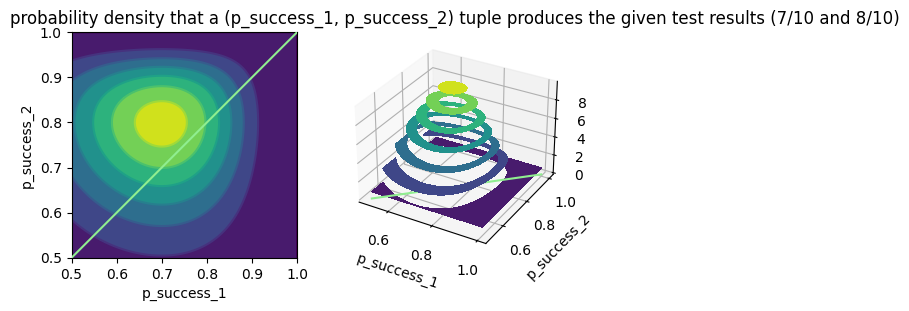

In [70]:
import matplotlib.pyplot as plt
from sympy.utilities.lambdify import lambdify

fxy = np.vectorize(lambdify([p1,p2], Pprod_given))

range_lo = 0.5 # adapt plot range here
range_hi = 1.0
xx, yy = np.meshgrid(np.linspace(range_lo, range_hi,101), np.linspace(range_lo, range_hi, 101))
zz = fxy(xx,yy)

fig = plt.figure()

ax = fig.add_subplot(1,2,1)
ax.set_aspect('equal') # only available in 2D
ax.set_xlabel("p_success_1"); ax.set_ylabel("p_success_2"); 
ax.plot([range_lo,range_hi],[range_lo,range_hi], color='lightgreen',zorder=3)

c = ax.contourf(xx, yy, zz)
c = ax.contour(xx, yy, zz)
#ax.clabel(c, c.levels, inline=True, colors="c")

ax3 = fig.add_subplot(1,2,2, projection='3d')
ax3.set_xlabel("p_success_1"); ax3.set_ylabel("p_success_2"); 
ax3.set_title(f'probability density that a (p_success_1, p_success_2) tuple produces the given test results ({n_successes_1}/{n_trials_1} and {n_successes_2}/{n_trials_2})')
ax3.contourf(xx, yy, zz)
ax3.plot([range_lo,range_hi],[range_lo,range_hi], color='lightgreen',zorder=3)

print("Plotted in green is the diagonal.")
print("Below the diagonal is where p_success_2 is lower than p_success_1 and still the results look like series2 is more successful.")

## Summary

In [71]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

assert n_successes_2/n_trials_2 >= n_successes_1/n_trials_1, 'The summary text below is written assuming n_successes_2/n_trials_2 >= n_successes_1/n_trials_1' 

In [72]:
printmd(f"With the assumptions you make, your seemingly improved test results **can happen by luck** in **{round(P_getResultsViap2ltp1.evalf(), round_to_digits)*100}%**" + \
        f" of similar test series **even when the actual sucess probability is equal or worse in series2**.") 


With the assumptions you make, your seemingly improved test results **can happen by luck** in **31.76%** of similar test series **even when the actual sucess probability is equal or worse in series2**.

#### Bonus: works for more prior functions, usues numerical integration

In [73]:
# similar to above but via numerical integration.
# just for future reference.
import numpy as np
from scipy.integrate import quadrature

import sympy
p1, p2 = symbols('p1 p2', real=True, positive=True)
fxy = np.vectorize(sympy.lambdify([p1,p2], L1_(p1)*L2_(p2)))

# Perform the first integration with respect to x
def integrand(x, y):
    return fxy(x, y)

TOL = 1.49e-8
# Use quadrature to integrate with respect to x=y..1 while y is fixed
def integrate_x_from_y_to_1(y):
    result, error = quadrature(integrand, y, 1, args=(y,), tol=TOL)
    return result
# Use quadrature to integrate with respect to x=0..1 while y is fixed
def integrate_x_from_0_to_1(y):
    result, error = quadrature(integrand, 0, 1, args=(y,), tol=TOL)
    return result

# Perform the second integration with respect to y and x >= y
def integrand_y_x_ge_y(y):
    return np.vectorize(integrate_x_from_y_to_1)(y)
# .. with respect to y and x >= 0
def integrand_y_x_ge_0(y):
    return np.vectorize(integrate_x_from_0_to_1)(y)

norm, error = quadrature(integrand_y_x_ge_0, 0, 1, tol=TOL)
integral_x_ge_y, error = quadrature(integrand_y_x_ge_y, 0, 1,tol=TOL)

p_get_result_while_series1_better_series2 = integral_x_ge_y/norm
p_get_result_while_series1_better_series2

0.31666323270034163